# GRU Profundo (Stacked, Soma das Próximas 4 Semanas)

Este notebook implementa o modelo GRU profundo (stacked) para previsão da **soma das próximas 4 semanas** (previsão mensal) das taxas de morbidade respiratória em municípios brasileiros.

- **Modelo:** GRU Profundo (Stacked)
- **Alvo:** Soma das próximas 4 semanas (previsão mensal)
- **Input:** sequência de 24 semanas (shape: [batch, 24, 1])
- **Arquitetura:** GRU(64, return_sequences=True) → Dropout(0.2) → GRU(32, return_sequences=False) → Dense(1)
- **Perda:** Huber ou MAE
- **Todo o código é modular e importado dos módulos `src/`.**

In [1]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"Project root: {project_root}")

# Add the project root to sys.path (not the src directory)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to sys.path")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from src.preprocessing import load_city_data, prepare_data_for_model, filter_city, clean_timeseries
from src.models import build_stacked_gru
from src.train import train_model, evaluate_model, generate_forecasts, save_predictions, save_metrics
from src.utils import plot_forecast, plot_forecast_error, plot_training_history

results_dir = os.path.join('results', 'gru_stacked')
os.makedirs(results_dir, exist_ok=True)

np.random.seed(42)

Project root: c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models
Added c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models to sys.path


## Estrutura do Repositório

- **data/**: Um CSV por cidade, cada um com coluna de data, coluna alvo e features opcionais.
- **notebooks/**: Notebooks para cada experimento. Apenas visualização e exploração.
- **src/**: Módulos reutilizáveis:
    - `preprocessing.py`: Carregamento, normalização, split, criação de janelas
    - `models.py`: Definições de modelos (baselines, MLP, LSTM, GRU, etc.)
    - `train.py`: Rotinas de treino e avaliação
    - `utils.py`: Funções auxiliares (plot, métricas, etc.)
- **results/**: Previsões e métricas salvas.
- **instructions.md**: Guia de boas práticas.

**Toda a lógica central está em `src/`.**

## Carregamento e Exploração dos Dados

Carregue os dados de morbidade respiratória para análise. Você pode iterar sobre todas as cidades ou selecionar uma específica.

In [2]:
# Exemplo: Carregar dados de uma cidade (ajuste o caminho conforme necessário)
data_path = '../data/df_base_morb_circ.csv'
df = load_city_data(data_path)

print(f"Formato do dataset: {df.shape}")
df.head()

Formato do dataset: (6344064, 11)


,CD_MUN,target,week,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
0,1100015,0.199872,1,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
1,1100015,1.304184,2,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
2,1100015,2.495194,3,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
3,1100015,3.538533,4,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
4,1100015,11.927224,5,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39


In [3]:
print("Colunas disponíveis:")
print(df.columns.tolist())
df.describe()

Colunas disponíveis:
['CD_MUN', 'target', 'week', 'PIB', 'DENS', 'URB', 'CO2', 'CH4', 'N2O', 'LAT', 'LON']


,CD_MUN,target,week,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
count,6.344064e+06,6.344064e+06,6.344064e+06,5.726592e+06,5.726592e+06,5.726592e+06,5.726592e+06,5.726592e+06,5.726592e+06,5.726592e+06,5.726592e+06
mean,3.241650e+06,1.466050e+01,5.765000e+02,3.567274e+03,6.938194e+01,9.914410e-03,2.764112e+04,5.971645e+02,9.700125e+00,-1.633024e+01,-4.632234e+01
std,9.796875e+05,1.413721e+01,3.325537e+02,3.776046e+03,3.433605e+02,4.076758e-02,9.569834e+04,1.030329e+04,6.801206e+01,8.333191e+00,6.413752e+00
min,1.100015e+06,0.000000e+00,1.000000e+00,6.250900e+02,8.923965e-02,7.131810e-07,0.000000e+00,0.000000e+00,0.000000e+00,-3.365254e+01,-7.348400e+01
25%,2.511202e+06,5.462076e+00,2.887500e+02,1.482630e+03,1.060286e+01,9.285660e-04,3.303876e+03,5.740669e+01,3.770217e+00,-2.274837e+01,-5.090800e+01
50%,3.144672e+06,1.158872e+01,5.765000e+02,2.745460e+03,2.250040e+01,2.147080e-03,7.940410e+03,1.100078e+02,6.881932e+00,-1.780183e+01,-4.651900e+01
75%,4.116604e+06,2.015466e+01,8.642500e+02,4.477390e+03,4.406899e+01,5.144121e-03,1.802659e+04,1.875715e+02,1.023172e+01,-8.379808e+00,-4.159900e+01
max,5.300108e+06,2.106944e+03,1.152000e+03,1.220112e+05,1.276356e+04,9.601277e-01,2.074703e+06,4.818822e+05,3.683565e+03,4.685425e+00,-3.487000e+01


## Seleção e Limpeza de Cidade

Selecione uma cidade específica para modelagem e limpe a série temporal.

In [20]:
# Select city for modeling (set to None to use all cities)
CD_MUN_SELECTED = 3550308  # São Paulo

df_city = filter_city(df, cd_mun=CD_MUN_SELECTED)
df_city = clean_timeseries(df_city, target_column='target')
print(f"Selected city shape: {df_city.shape}")

Selected city shape: (1152, 11)


## Pré-processamento

Prepare os dados para o modelo GRU profundo. O input é uma sequência de 24 semanas.

In [21]:
# Set the correct target column
model_params = {
    'sequence_length': 12,
    'forecast_horizon': 4,  # Soma das próximas 4 semanas (previsão mensal)
    'normalization': 'zscore',
    'val_size': None
}
target_column = 'target'

data_dict = prepare_data_for_model(
    df=df_city,
    target_column=target_column,
    sequence_length=model_params['sequence_length'],
    forecast_horizon=model_params['forecast_horizon'],
    normalization=model_params['normalization'],
    val_size=model_params.get('val_size', None)
)

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict.get('X_val', None)
y_val = data_dict.get('y_val', None)
X_test = data_dict['X_test']
y_test = data_dict['y_test']
test_df = data_dict['test_df']
scaler = data_dict.get('scaler')
feature_columns = data_dict.get('feature_columns', None)

## Definição e Treinamento do Modelo

O modelo GRU profundo utiliza duas camadas GRU empilhadas e dropout.

In [22]:
input_shape = X_train.shape[1:]
model = build_stacked_gru(input_shape=input_shape, loss='huber')

history = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    batch_size=32,
    epochs=400,
    patience=40,
    verbose=1
)

Epoch 1/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.9964 - val_loss: 1.4555 - learning_rate: 0.0010
Epoch 2/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1910 - val_loss: 1.2902 - learning_rate: 0.0010
Epoch 3/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0729 - val_loss: 1.2804 - learning_rate: 0.0010
Epoch 4/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0881 - val_loss: 1.2874 - learning_rate: 0.0010
Epoch 5/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0390 - val_loss: 1.2552 - learning_rate: 0.0010
Epoch 6/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0687 - val_loss: 1.2396 - learning_rate: 0.0010
Epoch 7/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0583 - val_loss: 1.2006 - learning_rate: 0.0010
Epoch 8/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9838 - val_loss: 1.0806 - learning_rate: 0.0010
Epoch 9/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9751 - val_loss: 0.9462 - learning_rate: 0.0010
Epoch 10/400
31/31

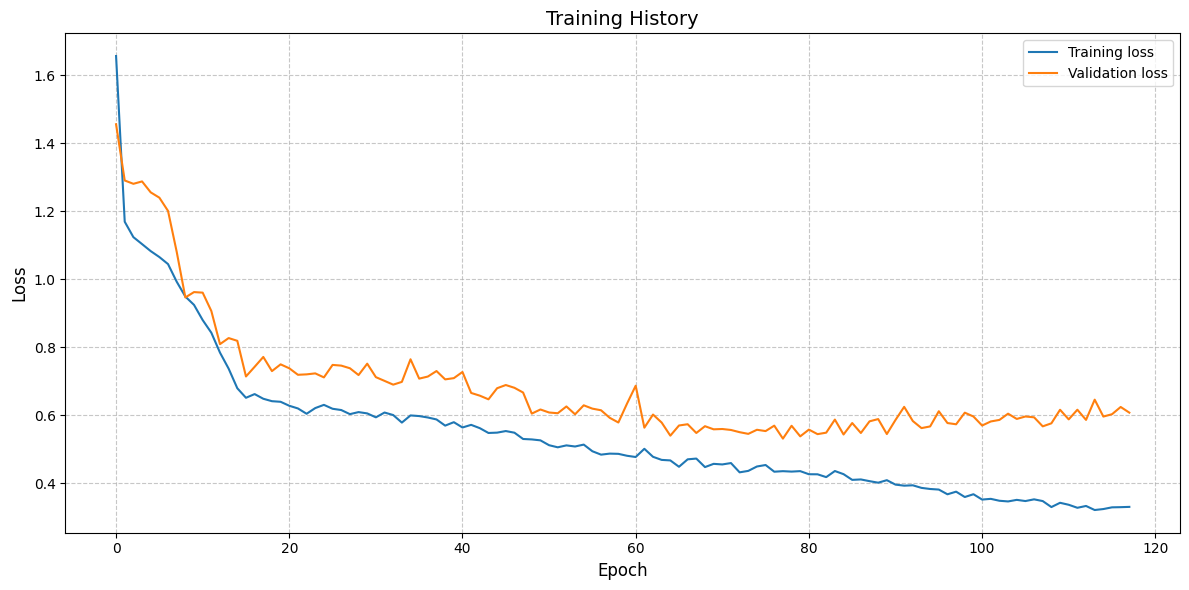

In [26]:

plot_training_history(history)
plt.show()

## Avaliação do Modelo

Calcule MAE, RMSE e R² para o modelo GRU profundo.

In [ ]:
metrics = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,  # y_test is the sum of scaled values
    scaler=scaler,
    forecast_horizon=model_params['forecast_horizon']  # Pass the forecast horizon
)

print("Métricas de Avaliação:")
print(f"MAE: {metrics['mae']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"R²: {metrics['r2']:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Métricas de Avaliação:
MAE: 3.2959
RMSE: 3.7801
R²: -3.4450


## Visualização dos Resultados

Plote os valores reais versus previstos e o erro de previsão. O alvo é a **soma das próximas 4 semanas** (previsão mensal).

In [ ]:
def reduce_to_1d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr
    if arr.ndim == 2:
        if arr.shape[1] == 1:
            return arr.ravel()
        else:
            # This case should ideally not be hit if y_test/y_pred are already sums or single predictions
            # If it's a multi-output model predicting multiple steps (not sum), this would need adjustment
            print("Warning: reduce_to_1d received a 2D array with more than one column. Summing along axis 1.")
            return arr.sum(axis=1)
    raise ValueError(f"Unexpected array shape for reduce_to_1d: {arr.shape}")

# y_test from prepare_data_for_model is already the scaled sum (1D)
# y_pred from generate_forecasts(model, X_test) is model's direct output, usually (n_samples, 1) for single target
y_test_scaled_sum = reduce_to_1d(y_test) 
y_pred_scaled_sum = reduce_to_1d(generate_forecasts(model, X_test))

# ADD THESE PRINT STATEMENTS FOR DIAGNOSIS (using the more descriptive names):
print(f"Scaled y_test_sum (first 10): {y_test_scaled_sum[:10]}")
print(f"Mean of scaled y_test_sum: {np.mean(y_test_scaled_sum):.4f}, Std: {np.std(y_test_scaled_sum):.4f}")
print(f"Scaled y_pred_sum (from model, first 10): {y_pred_scaled_sum[:10]}")
print(f"Mean of scaled y_pred_sum: {np.mean(y_pred_scaled_sum):.4f}, Std: {np.std(y_pred_scaled_sum):.4f}")
if scaler:
    print(f"Scaler original mean (for single value): {scaler.mean_[0]:.4f}, Scaler original scale/std (for single value): {scaler.scale_[0]:.4f}")

# Correctly descale the sums for plotting and saving
y_test_denorm_sum = y_test_scaled_sum
y_pred_denorm_sum = y_pred_scaled_sum

if scaler is not None and hasattr(scaler, 'scale_') and hasattr(scaler, 'mean_'):
    forecast_horizon_val = model_params['forecast_horizon']
    target_idx = 0 # Assuming single target feature
    
    y_test_denorm_sum = y_test_scaled_sum * scaler.scale_[target_idx] + forecast_horizon_val * scaler.mean_[target_idx]
    y_pred_denorm_sum = y_pred_scaled_sum * scaler.scale_[target_idx] + forecast_horizon_val * scaler.mean_[target_idx]

# test_dates should align with the length of the denormalized sums
test_dates = test_df['week'].values[-len(y_test_denorm_sum):] if 'week' in test_df.columns and len(test_df['week'].values) >= len(y_test_denorm_sum) else np.arange(len(y_test_denorm_sum))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\pedro\AppData\Local\Temp\ipykernel_27752\2339613305.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\pedro\AppData\Local\Temp\ipykernel_27752\2339613305.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


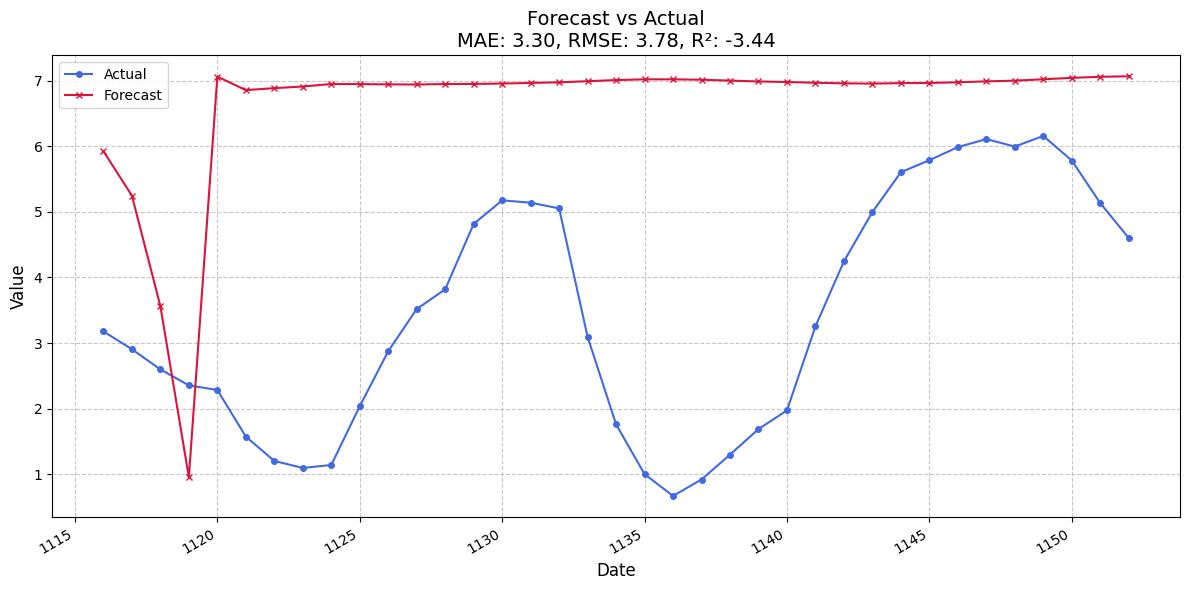

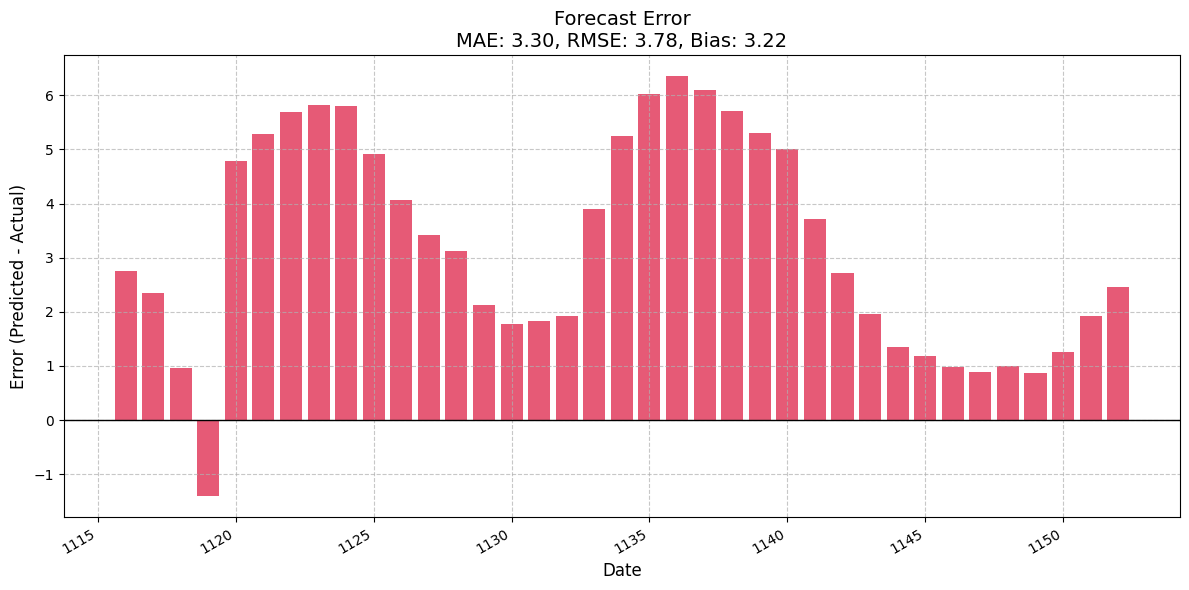

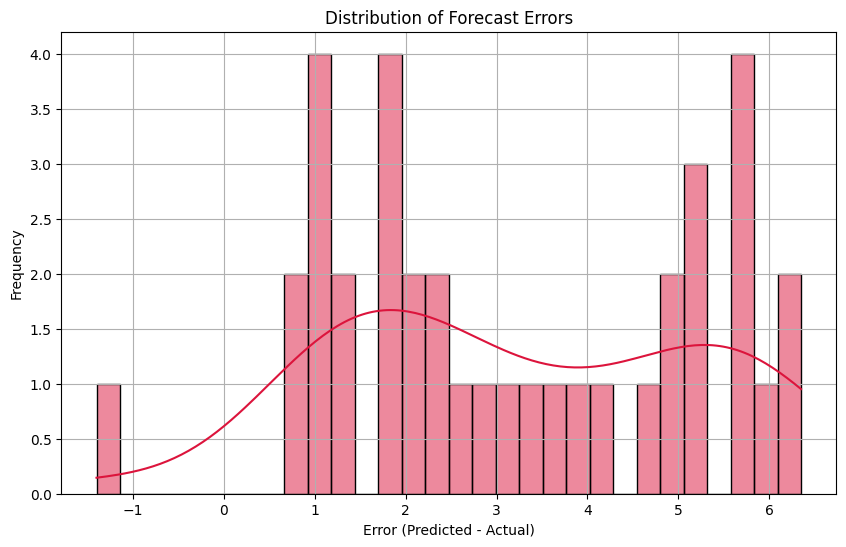

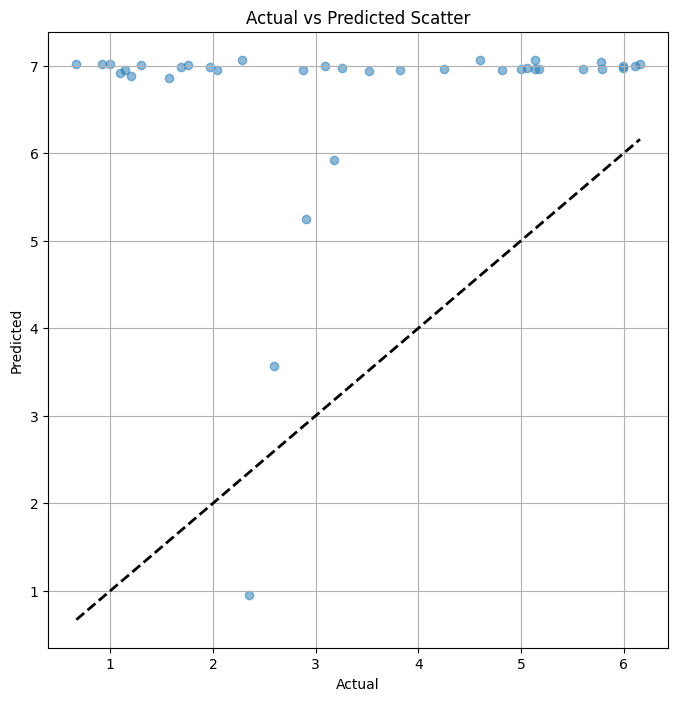

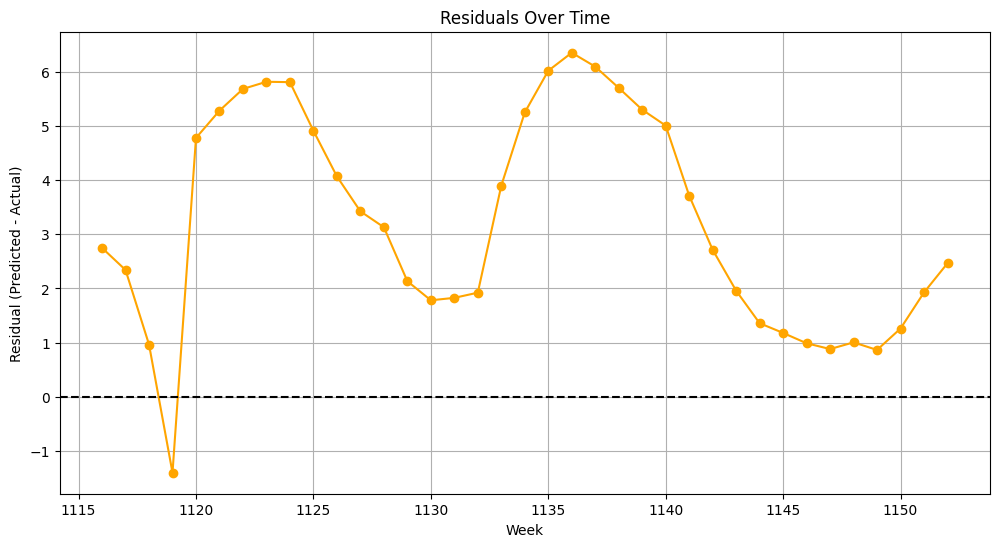

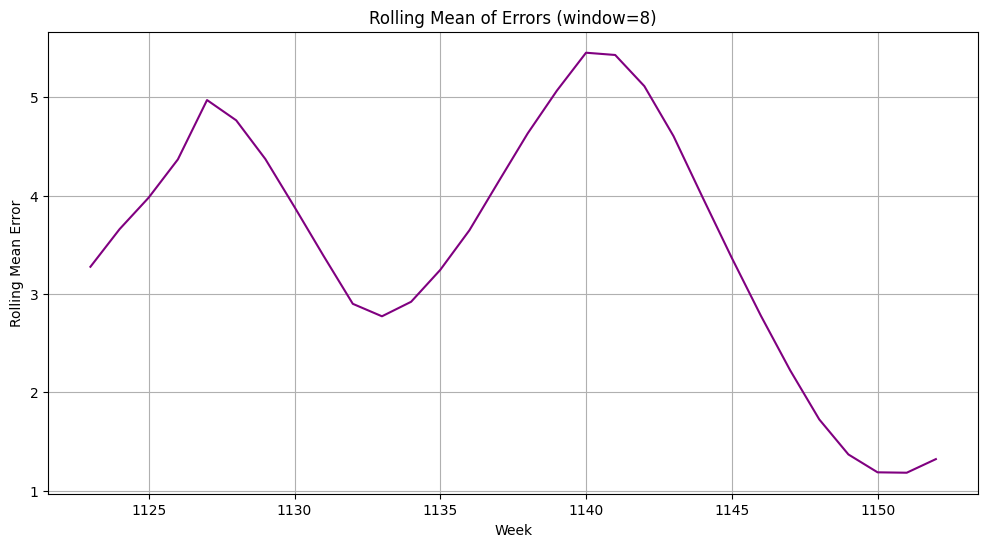

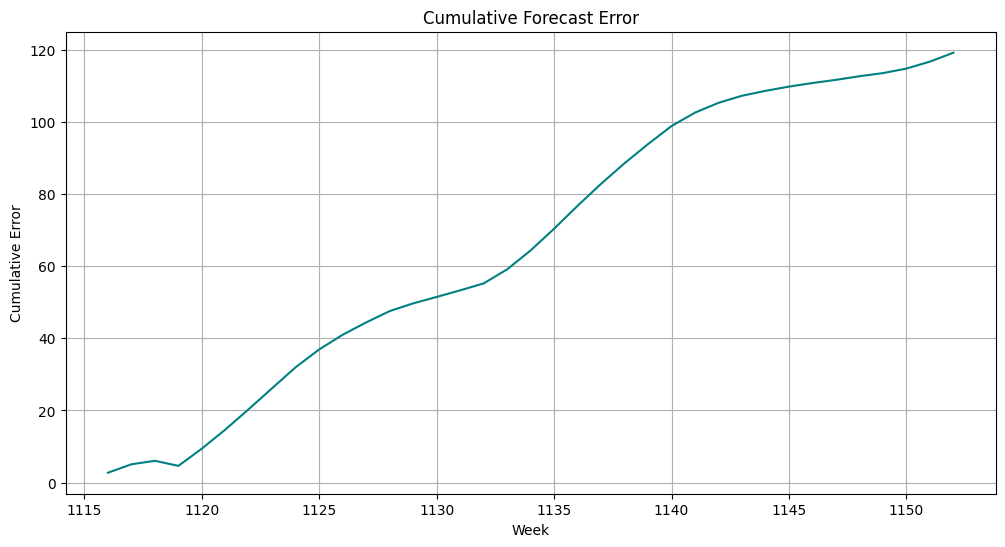

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Scaled y_test (summed, first 10): [-4.73118986 -4.91083922 -5.1147826  -5.27593121 -5.32287033 -5.79337901
 -6.03961373 -6.11040941 -6.08075288 -5.4869723 ]
Mean of scaled y_test: -4.5650, Std: 1.1882
Scaled y_pred (summed from model, first 10): [-2.909863  -3.3594694 -4.476016  -6.205353  -2.156183  -2.2928443
 -2.2732756 -2.2564626 -2.231493  -2.232274 ]
Mean of scaled y_pred: -2.4310, Std: 0.7558
Scaler mean: 10.3167, Scaler scale (std): 1.5089
Scaled y_test (summed, first 10): [-4.73118986 -4.91083922 -5.1147826  -5.27593121 -5.32287033 -5.79337901
 -6.03961373 -6.11040941 -6.08075288 -5.4869723 ]
Mean of scaled y_test: -4.5650, Std: 1.1882
Scaled y_pred (summed from model, first 10): [-2.909863  -3.3594694 -4.476016  -6.205353  -2.156183  -2.2928443
 -2.2732756 -2.2564626 -2.231493  -2.232274 ]
Mean of scaled y_pred: -2.4310, Std: 0.7558
Scaler mean: 10.3167, Scaler scale (std): 1.5089


In [ ]:
# --- Advanced Evaluation and Visualization ---
# IMPORTANT: Using y_test_denorm_sum and y_pred_denorm_sum for all plots and calculations below

# 1. Forecast vs Actual
fig1 = plot_forecast(y_test_denorm_sum, y_pred_denorm_sum, dates=test_dates, title="Forecast vs Actual (Corrected Descaling)")
fig1.show()

# 2. Forecast Error
fig2 = plot_forecast_error(y_test_denorm_sum, y_pred_denorm_sum, dates=test_dates, title="Forecast Error (Corrected Descaling)")
fig2.show()

# 3. Distribution of Errors
errors = y_pred_denorm_sum - y_test_denorm_sum
plt.figure(figsize=(10,6))
sns.histplot(errors, kde=True, bins=30, color='crimson')
plt.title('Distribution of Forecast Errors (Corrected Descaling)')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8,8))
plt.scatter(y_test_denorm_sum, y_pred_denorm_sum, alpha=0.5)
plt.plot([y_test_denorm_sum.min(), y_test_denorm_sum.max()], [y_test_denorm_sum.min(), y_test_denorm_sum.max()], 'k--', lw=2)
plt.xlabel('Actual (Corrected Descaling)')
plt.ylabel('Predicted (Corrected Descaling)')
plt.title('Actual vs Predicted Scatter (Corrected Descaling)')
plt.grid(True)
plt.show()

# 5. Residuals Over Time
plt.figure(figsize=(12,6))
plt.plot(test_dates, errors, marker='o', linestyle='-', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time (Corrected Descaling)')
plt.xlabel('Week')
plt.ylabel('Residual (Predicted - Actual)')
plt.grid(True)
plt.show()

# 6. Rolling Mean of Errors
window = 8 
# Ensure errors series is long enough for rolling window
if len(errors) >= window:
    rolling_error = pd.Series(errors).rolling(window=window).mean()
    plt.figure(figsize=(12,6))
    plt.plot(test_dates[window-1:], rolling_error.dropna(), color='purple') # Adjust dates for rolling window
    plt.title(f'Rolling Mean of Errors (window={window}, Corrected Descaling)')
    plt.xlabel('Week')
    plt.ylabel('Rolling Mean Error')
    plt.grid(True)
    plt.show()
else:
    print(f"Skipping rolling mean of errors plot as data length ({len(errors)}) is less than window size ({window}).")

# 7. Cumulative Error
cumulative_error = np.cumsum(errors)
plt.figure(figsize=(12,6))
plt.plot(test_dates, cumulative_error, color='teal')
plt.title('Cumulative Forecast Error (Corrected Descaling)')
plt.xlabel('Week')
plt.ylabel('Cumulative Error')
plt.grid(True)
plt.show()

# The redundant reduce_to_1d function definition and subsequent y_test_1d/y_pred_1d re-assignments
# and diagnostic prints are removed from here as they are now handled in the cell above (ID 89324dad).
# The descaling logic is also handled in the cell above.
# Ensure test_dates is correctly defined in the cell above based on y_test_denorm_sum.

## Salvar Resultados

Salve as previsões e métricas para comparação posterior.

In [ ]:
# Salvar previsões
# Ensure y_test_denorm_sum and y_pred_denorm_sum are used for saving predictions
preds_file = save_predictions(
    y_true=y_test_denorm_sum, # Use correctly descaled actuals
    y_pred=y_pred_denorm_sum, # Use correctly descaled predictions
    dates=test_dates,
    city_name='São Paulo',
    model_name='gru_stacked',
    output_dir=results_dir
)
print(f"Previsões salvas em: {preds_file}")

# Salvar métricas
# Metrics are already calculated with correct descaling by the updated evaluate_model
metrics_file = save_metrics(
    metrics=metrics,
    city_name='São Paulo',
    model_name='gru_stacked',
    output_dir=results_dir,
    params=model_params
)
print(f"Métricas salvas em: {metrics_file}")

Previsões salvas em: results\gru_stacked\São Paulo_gru_stacked_preds.csv
Métricas salvas em: results\gru_stacked\São Paulo_gru_stacked_metrics.csv


## Conclusão

O modelo GRU profundo (stacked) permite capturar padrões temporais mais complexos. Compare seu desempenho com outros modelos nos próximos notebooks.